# Hito 3: Corona virus (Covid-19)

## Presentación

Somos el equipo conformado por Raúl Cid, José Espina, Michelle Valenzuela y Alejandro Veragua. Nuestro *dataset* corresponde al [publicado en el portal Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) construido y mantenido por la Universidad John Hopkins, al igual que para el hito 1

## Comentarios sobre el hito 1

Se realizó un análisis exploratorio, donde descubrimos varios datos inconsistentes y outliers
Se buscaron correlaciones contra atributos como el ingreso per cápita, la temperatura, el índice de pobreza de los diferentes países, pero sin éxito. Finalmente se realizó una prueba de concepto de clústering a partir de los coeficientes de un modelo de regeresión polinomial donde sí aparecieron resultados interesantes

## Propuesta del hito 3
Considerando que los polinomios hacen "overfitting" cuando el grado es muy alto, como el ejercicio realizado en el hito 1, aprovecharemos hacer algo similar, con la diferencia de usar un modelo auto-regresivo y hacer clustering sobre los coeficientes que resulten del modelo. En particular, quisimos experimentar con un modelo auto-regresivo con media móvil (ARMA). Como se tienen datos sólo de los últimos meses y el virus es nuevo, los datos no son estacionarios (o no hay suficientes datos para demostrar que lo son), por lo que usaremos una variante llamada ARIMA (donde la "i" hace referencia a la integración), que permite encontrar las diferencias no-estacionarias para lograr la estacionariedad (https://www.statisticshowto.com/arma-model/)

Además, se refuerza la idea de usar el modelo ARIMA ya que lo usan en 2 artículos publicados en la literatura:
1) Benvenuto, D., Giovanetti, M., Vassallo, L., Angeletti, S., & Ciccozzi, M. (2020). Application of the ARIMA model on the COVID-2019 epidemic dataset. Data in brief, 105340.
2) Yang, Q., Wang, J., Ma, H., & Wang, X. (2020). Research on COVID-19 Based on ARIMA ModelΔ—Taking Hubei, China as an example to see the epidemic in Italy. Journal of Infection and Public Health.

## Metodología de trabajo para el hito 3
Los siguientes pasos describen, a grandes rasgos, nuestra metodología planificada:
* Preprocesamiento de los datos, con el objetivo de remover los datos outliers. Descubrimos en el hito 1 que hay paises con datos demasiado alejados de la tendencia central, retroceso en datos acumulados (que debiesen ser estrictamente crecientes) y datos con ruido, como los del crucero Diamond Princess
* Cálculo de coeficientes de modelo predictivo ARIMA, y su predicción para Chile
* Clustering de los coeficientes

###NOTA IMPORTANTE 1
Para ejecutar este notebook, se necesitan scikit, matplotlib, numpy y statsmodels. Éste último para poder aplicar el modelo ARIMA. Se debe instalar con pip en el ambiente del libro:

$ pip install statsmodels

o con conda:

$ conda install -c conda-forge statsmodels

(https://www.statsmodels.org/stable/install.html)

###NOTA IMPORTANTE 2
Calcular el modelo ARIMA toma un tiempo de cómputo importante

## Configuración base del notebook
El bloque a continuación configura el libro, definiendo funciones y cargando las fuentes de datos

In [46]:
# Librería de álgebra lineal
import numpy as np 
# Procesamiento de datos y carga de archivos CSV
import pandas as pd
# Librearía gráfica
import matplotlib.pylab as plt
# Librería para usar recursos del sistema operativo
import os 
# Librearía usada para extraer el nombre del archivo de cada path
import ntpath
# Librería gráfica
import seaborn as sns
# Librearía para usar herramientas relacionadas con
# aprendizaje máquina. Se usó para preprocesar y
# calcular regresión
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Colores
from matplotlib import colors
# Ticker
import matplotlib.ticker as ticker
# Animation
import matplotlib.animation as animation
# Arima
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
# Configuración general
%load_ext autoreload
%autoreload 2

# Matplotlib inline
%matplotlib notebook
%matplotlib inline

# Se prepara carga de los archivos del dataset
paths = []
for dirname, _, filenames in os.walk('./novel-corona-virus-2019-dataset'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path);
dataFrames = {}
for path in paths:
    dataFrames[ntpath.basename(path)] = pd.read_csv(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Carga y reduce de datos por dia

Se agrupan los atributos por indexados por fecha y país, para una manipulación más simple de los datos

In [47]:
from atributos_extra.correccion_nombres import cargar_correccion, atributos_extra
covid19Data = dataFrames['covid_19_data.csv'].copy()
dict_error, dict_pares = cargar_correccion()
group_covid_data, paises_covid_df = atributos_extra(covid19Data, dict_error)
group_covid_data.columns = group_covid_data.columns.droplevel(1)
group_covid_data['ObservationDate'] = pd.to_datetime(group_covid_data['ObservationDate'])
group_covid_data.set_index('Country/Region', inplace=True)
group_covid_data.set_index('ObservationDate', inplace=True, append=True)
group_covid_data.drop('Last Update', axis=1, inplace=True)

In [3]:
group_covid_data.loc['Chile']

,SNo,Confirmed,Deaths,Recovered
ObservationDate,,,,
2020-03-03,3199,1.0,0.0,0.0
2020-03-04,3358,1.0,0.0,0.0
2020-03-05,3488,4.0,0.0,0.0
2020-03-06,3671,4.0,0.0,0.0
2020-03-07,3876,4.0,0.0,0.0
...,...,...,...,...
2020-07-28,1260668,349800.0,9240.0,322332.0
2020-07-29,1273299,351575.0,9278.0,324557.0
2020-07-30,1285930,353536.0,9377.0,326628.0


## Calcular fenomeno por dia, basado en acumulados

En el dataset vienen los acumulados de los contagios, fallecidos y recuperados. Se implementa un pequeño algoritmo que permite calcular los esos mismos atributos para cada día. Además, determinamos la fecha del primer contagio, de tal manera de tener una columna con el número de día desde el primer contagio, con el fin de poder comparar los países entre sí

In [48]:
import datetime
def apply_primer_dia(data):
    date_inicio_dataset = pd.to_datetime('22/01/2020') #datetime.date(2020,1,22)
    #data = data.sort_index(ascending=True, level=0)
    observation_date = data.index.get_level_values(1)
    
    num_dia_desde_primer_caso = 0
    data[ 'num_dia_desde_22_enero'] = observation_date - date_inicio_dataset
    
    fecha_primer_caso = observation_date.min()
    data['num_dia_desde_primer_caso'] = observation_date - fecha_primer_caso
    # Set indexed
    data.set_index('num_dia_desde_primer_caso', inplace=True, append=True)
    # data.set_index('num_dia_desde_22_enero', inplace=True, append=True)
    data.reset_index(level=1, inplace=True)
    return data

def compute_diff(col):
    diff = col - col.shift(periods=1)
    diff[0] = col[0]
    # print(col[10])
    # print(diff[9])
    # print(20*'-')
    return diff

def apply_por_dia(data):
    data['num_confirmados'] = compute_diff(data['Confirmed'])
    data['num_recuperados'] = compute_diff(data['Recovered'])
    data['num_fallecidos'] = compute_diff(data['Deaths'])
    return data

data = (
    group_covid_data
        .groupby('Country/Region')
        .apply(lambda country: apply_primer_dia(country))
        .droplevel(1)
        .groupby(level=0)
        .apply(lambda country: apply_por_dia(country))
)

data.loc['Chile'].sort_index(ascending=False).head(5)

,ObservationDate,SNo,Confirmed,Deaths,Recovered,num_dia_desde_22_enero,num_confirmados,num_recuperados,num_fallecidos
num_dia_desde_primer_caso,,,,,,,,,
151 days,2020-08-01,1311192,357658.0,9533.0,330507.0,192 days,1991.0,2180.0,76.0
150 days,2020-07-31,1298561,355667.0,9457.0,328327.0,191 days,2131.0,1699.0,80.0
149 days,2020-07-30,1285930,353536.0,9377.0,326628.0,190 days,1961.0,2071.0,99.0
148 days,2020-07-29,1273299,351575.0,9278.0,324557.0,189 days,1775.0,2225.0,38.0
147 days,2020-07-28,1260668,349800.0,9240.0,322332.0,188 days,1877.0,2378.0,53.0


## ¿Como se comporta Chile en cantidad de confirmados?
Se puede apreciar el "pic" en el momento en que el MISNAL corrigió los datos

Además, se puede ver que había una tendencia a la baja que se rompe en los últimos días

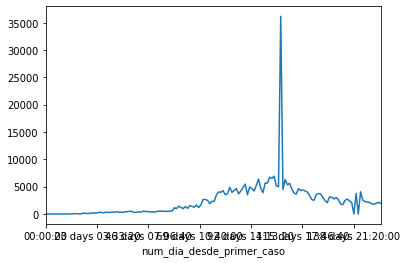

In [49]:
data.loc['Chile']['num_confirmados'].plot()

### Preproceso: Outliers
Como parte del preprocesamiento, se realiza el siguiente tratamiento a los datos: Para cada país, se revisan las columnas de confirmados, fallecidos y recuperados. En cada una de ellas se buscan outliers, en este caso, valores que superen en magnitud al percentil 99 o que sean menores a cero. Estos se transorman a NaN y luego interpolamos los datos para llenar estos espacios.
Además, se debe recalcular la cantidad acumulada por día para cada columna.

In [7]:
def remove_outliers(dset_base, cols=['num_confirmados', 'num_fallecidos', 'num_recuperados']):  
    for pais in dset_base['Country/Region'].unique():
        for col in cols:
            pais_col = dset_base[dset_base['Country/Region']==str(pais)][col]
            changed_values = pd.Series(np.nan, index=pais_col.index)
            for value in pais_col.iteritems():
                if value[1] > pais_col.quantile(.99) or value[1] < 0:
                    changed_values[value[0]] = np.nan
                else:
                    changed_values[value[0]] = value[1]
            changed_values.interpolate(inplace=True)
            acc = changed_values.cumsum()
            dset_base.loc[(dset_base['Country/Region']==pais), col] = changed_values
            dset_base.loc[(dset_base['Country/Region']==pais), str('acc') + col[3:]] = acc
    return dset_base

In [50]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers(col, q=0.99):
    threshold = col.mean() + 3*col.std()
    # threshold = col.quantile(q)
    col[(col >= threshold)  | (col < 0)] = np.nan
    # col[(col >= col.quantile(q)) | (col < 0)] = np.nan
    #print(col.name, col.isna().sum())
    res = col.interpolate()
    return res

def apply_remove_outliers(pais_col, cols=['num_confirmados', 'num_recuperados']):
    # print(pais_col.name)
    pais_col[cols] = pais_col[cols].apply(lambda x: remove_outliers(x))
    # print(pais_col[cols].isna().sum())
    return pais_col

def compute_acumulados(pais_col):
    pais_col['Confirmed'] = pais_col['num_confirmados'].cumsum()
    pais_col['Recovered'] = pais_col['num_recuperados'].cumsum()
    pais_col['Deaths'] = pais_col['num_fallecidos'].cumsum()
    pais_col = pais_col.rename(
        columns={
            'Confirmed': 'acc_confirmados',
            'Recovered': 'acc_recuperados',
            'Deaths': 'acc_fallecidos'
        }
    )
    return pais_col
# data = data.drop('Papua New Guinea')
res = (
    data
        .groupby(level=0)
        .apply(lambda pais_col: apply_remove_outliers(pais_col))
    )

# Laos tiene un outliers que por alguna razon no se imputa
res.loc['Laos', '0'] = data.loc['Laos', '0']
# Calculamos los acumulados
res = (res
    .groupby(level=0)
    .apply(lambda pais_col: compute_acumulados(pais_col))
    )

### Datos limpios

Ahora contamos con los datos limpios de anomalías estadísticas, agrupados por país y fecha, aprovechando la capacidad de los índices del tipo de datos DataFrame del módulo Pandas

In [9]:
res.loc['Chile'].sort_index(level=0, ascending=False).head(5)

,ObservationDate,SNo,acc_confirmados,acc_fallecidos,acc_recuperados,num_dia_desde_22_enero,num_confirmados,num_recuperados,num_fallecidos
num_dia_desde_primer_caso,,,,,,,,,
151 days,2020-08-01,1311192,326223.0,9533.0,262639.5,192 days,1991.0,2180.0,76.0
150 days,2020-07-31,1298561,324232.0,9457.0,260459.5,191 days,2131.0,1699.0,80.0
149 days,2020-07-30,1285930,322101.0,9377.0,258760.5,190 days,1961.0,2071.0,99.0
148 days,2020-07-29,1273299,320140.0,9278.0,256689.5,189 days,1775.0,2225.0,38.0
147 days,2020-07-28,1260668,318365.0,9240.0,254464.5,188 days,1877.0,2378.0,53.0


### ¿Como está Chile, en cantidad de confirmados, recuperados y fallecidos?

Ahora, con los datos limpios, es posible ver la progresión de contagios, recuperados y fallecidos en Chile

Por el momento, se podría pensar que lo pero ya pasó, sin embargo, en Europa los países han tenido rebrotes, como es el caso de Japón (ver figura a continuación a la de Chile)

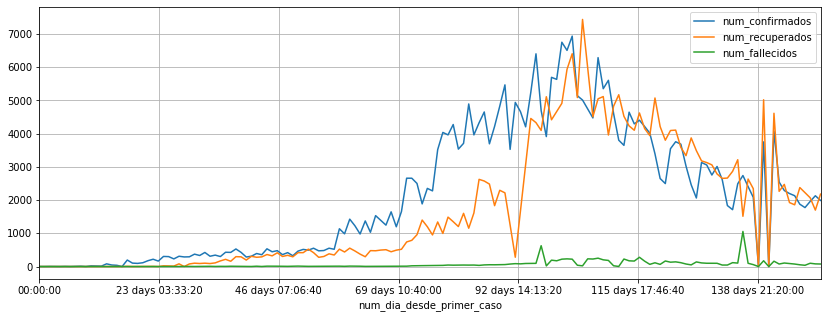

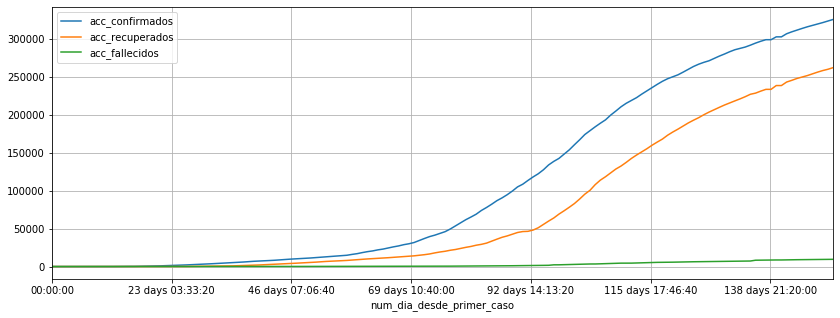

In [67]:
figsize = (14, 5)
res.loc['Chile'][['num_confirmados', 'num_recuperados', 'num_fallecidos']].plot(figsize=figsize, grid=True)
res.loc['Chile'][['acc_confirmados', 'acc_recuperados', 'acc_fallecidos']].plot(figsize=figsize, grid=True)


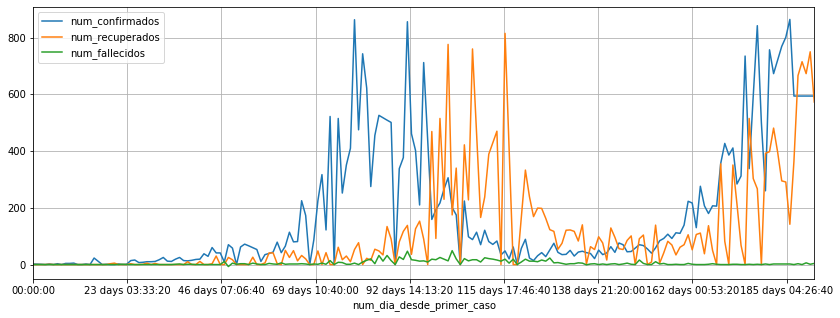

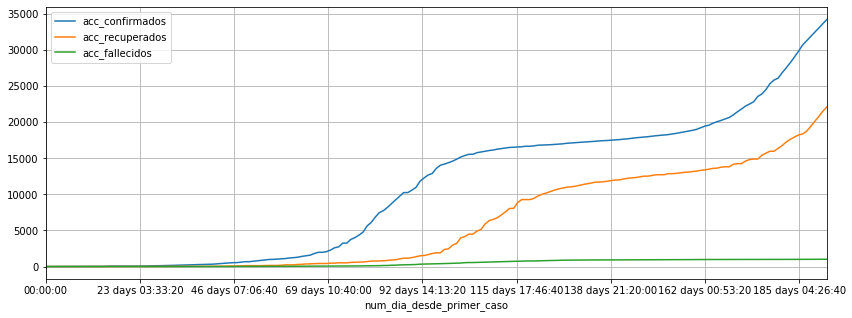

In [63]:
# Caso de rebrote en Japón, en el día 180, aproximadamente, desde el primer contagio
figsize = (14, 5)
res.loc['Japan'][['num_confirmados', 'num_recuperados', 'num_fallecidos']].plot(figsize=figsize, grid=True)
res.loc['Japan'][['acc_confirmados', 'acc_recuperados', 'acc_fallecidos']].plot(figsize=figsize, grid=True)

## "Polinomial features"

Se procede a repetir el experimento del hito 1 con los datos actualizados. Nos gustaría demostrar que agrupar (cluster) mediante los coeficientes de ARIMA es mejor idea que con los polinomios, que fue lo que hicimos la primera oportunidad

0    1.000000e+00
1    1.510000e+02
2    2.280100e+04
3    3.442951e+06
4    5.198856e+08
5    7.850273e+10
6    1.185391e+13
dtype: float64


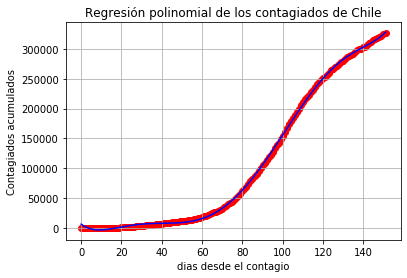

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
selected_pais = "Chile"
dset_pais = res.loc['Chile']
X = np.linspace((0,),(len(dset_pais.index)-1,),len(dset_pais.index))
y = dset_pais['acc_confirmados'].values
poly_reg = PolynomialFeatures(degree=6)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Regresión polinomial de los contagiados de Chile')
    plt.xlabel('dias desde el contagio')
    plt.ylabel('Contagiados acumulados')
    plt.savefig('figures/chile_polinomial_reg.png')
    plt.grid(True)
    return
viz_polymonial()
print(pd.Series(poly_reg.transform(X)[-1]))

In [624]:
pol.shape

(140, 45)

In [606]:
poly_reg.get_feature_names()

['1',
 'x0',
 'x1',
 'x0^2',
 'x0 x1',
 'x1^2',
 'x0^3',
 'x0^2 x1',
 'x0 x1^2',
 'x1^3',
 'x0^4',
 'x0^3 x1',
 'x0^2 x1^2',
 'x0 x1^3',
 'x1^4',
 'x0^5',
 'x0^4 x1',
 'x0^3 x1^2',
 'x0^2 x1^3',
 'x0 x1^4',
 'x1^5',
 'x0^6',
 'x0^5 x1',
 'x0^4 x1^2',
 'x0^3 x1^3',
 'x0^2 x1^4',
 'x0 x1^5',
 'x1^6',
 'x0^7',
 'x0^6 x1',
 'x0^5 x1^2',
 'x0^4 x1^3',
 'x0^3 x1^4',
 'x0^2 x1^5',
 'x0 x1^6',
 'x1^7',
 'x0^8',
 'x0^7 x1',
 'x0^6 x1^2',
 'x0^5 x1^3',
 'x0^4 x1^4',
 'x0^3 x1^5',
 'x0^2 x1^6',
 'x0 x1^7',
 'x1^8']

In [535]:

(
    data.loc[['Chile', 'US']]
    .groupby(level=0)
    .apply(lambda x: ajuste_polinomial(x))
)

KeyboardInterrupt: 

## Modelo ARIMA
Usamos un modelo ARIMA p=5,d=1,q=0. El detalle de estos parámetros se explica a continuación (basado en https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

* El parámetro "p" es el número de observaciones pasadas que considera el modelo. También se le llama "orden".
* El parámetro "d" es el grado de diferenciación. Esto se usa para generar estacionariedad en series no estacionarias
* El parámetro "q" es el tamaño de la media móvil para el error de los datos anteriores

In [64]:
# Se calculan coeficientes del ARIMA por país. Si ya está calculado se lee el csv
# Los parámetros usados se escogieron en base a la moda, al calcular el óptimo para cada país
dframe_arima = None
if os.path.isfile('arima_coefs.csv') :
    dframe_arima = pd.read_csv('arima_coefs.csv')
else :
    pais_arima_coef = dict()
    paises_error = []
    for pais in dset_base.pais.unique() :
        dbset_actual = dset_base[dset_base['pais']==pais][['num_dia_desde_primer_caso','num_confirmados']]
        dbset_actual= dbset_actual.reset_index()
        series_actual = pd.Series(dbset_actual.num_confirmados.values, index=dbset_actual.num_dia_desde_primer_caso)
        series_actual.index = pd.DatetimeIndex(series_actual.index).to_period('D')
        try :
            model = ARIMA(series_actual.astype(float), order=(5,1,0),missing="drop")
            model_fit = model.fit(disp=False)
            pais_arima_coef[pais] = model_fit.params
        except :
            paises_error.append(pais)
    dframe_arima = pd.DataFrame(data=pais_arima_coef)
    dframe_arima.to_csv('arima_coefs.csv')


### Coeficientes ARIMA

Se muestra un resumen de los coeficientes calculados del modelo ARIMA por país

In [66]:
dframe_arima

,Unnamed: 0,Japan,Mainland China,Thailand,US,Australia,Brazil,Colombia,Malaysia,Mexico,...,Laos,Mali,Botswana,Burundi,Sierra Leone,Malawi,South Sudan,Comoros,Tajikistan,Lesotho
0,const,2.546470,-2.407483,-0.001979,341.483197,1.915577,201.970739,46.308329,0.088641,40.494816,...,-0.008687,0.022948,-0.010913,0.035999,0.063980,0.688731,0.095112,0.017866,0.800274,0.228306
1,ar.L1.D.y,-0.812073,-0.382370,-0.516533,-0.094828,-0.586175,-0.075569,-0.907275,-0.503760,-0.446703,...,-0.653708,-0.853075,-0.577623,-0.818697,-0.990846,-0.990139,-0.883847,-1.067787,-0.453948,-0.825169
2,ar.L2.D.y,-0.558169,0.029824,-0.187264,-0.107447,-0.173611,-0.445638,-0.606958,-0.409088,-0.254138,...,-0.594049,-0.665380,-0.707078,-0.704873,-0.650032,-0.877224,-0.571077,-0.934370,-0.014313,-0.818254
3,ar.L3.D.y,-0.425487,0.002069,0.141996,-0.322335,0.123936,-0.291279,-0.531731,-0.124623,-0.445211,...,-0.488884,-0.473791,-0.363140,-0.560734,-0.425272,-0.634573,-0.545738,-0.562236,0.369286,-0.652442
4,ar.L4.D.y,-0.312385,-0.211648,0.140699,-0.149162,0.092516,-0.370785,-0.561831,-0.115668,-0.494059,...,0.011375,-0.194600,-0.147007,-0.431514,-0.230829,-0.275381,-0.272964,-0.282636,0.142863,-0.313236
5,ar.L5.D.y,-0.253820,0.108599,0.080296,-0.197575,0.096899,-0.362090,-0.313050,0.052761,-0.289385,...,-0.203855,0.009388,-0.217273,-0.299104,-0.043613,-0.182681,-0.163531,-0.121950,0.081358,-0.037310


## Predicción para Chile

En el anexo está el cómo encontrar los parámetros óptimos para Chile

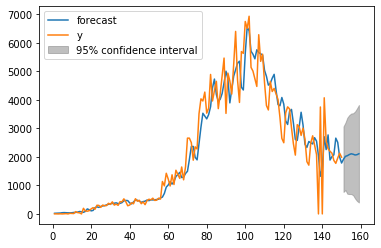

In [59]:
dbset_actual = res.loc['Chile']['num_confirmados']
dbset_actual= dbset_actual.reset_index()
series_actual = pd.Series(dbset_actual.num_confirmados.values, index=dbset_actual.num_dia_desde_primer_caso)
model = ARIMA(series_actual.astype(float), order=(6,0,0),missing="drop")
model_fit = model.fit(disp=False)
model_fit.plot_predict(2,160);

## Análisis de los resultados y discusión

- Es importante contar con datos suficientemente limpios (bien estructurados y poco ruido). No es menor la cantidad de tiempo invertido en la limpieza tanto para el hito 1 como este hito.
- El ruido de los datos se deriva principalmente del modo en que estos se han estado contabilizando por pais, por ejemplo: Para el caso de chile en la columan confirmados se presenta un peak que se eleva de 5000 a 35000 (aprox), este se debio a que el minsal no habia reportado una cantidad considerable de casos por considerarlos como 'pendientes'. La mayoria de los errores y ruidos en el dataset son de similar indole.
- Es importante eliminar o suavizar lo mas posible el ruido debido a que al realizar clustering se podria estar agrupando por 'tipo de ruido' y o por tipo de curva o evolucion. Se sigue una logica similar respecto a ruido y modelamiento.
- Se puede observar, en el gráfico de la predicción, que la cuarentena y el confinamiento han dado resultado y el país estaba bajando la tasa de contagio. Lamentablemente el gobierno está apresurando el regreso a "la normalidad", y podría suceder que haya un rebrote del virus
- Se puede observar en el gráfico, en la sección del clustering, que la idea de "clusterizar" los coeficientes del modelo predictivo ARIMA no funcionó, como sí había funcionado con los coeficientes del polinomio de regresión del hito 1
- Aún así, aprovechamos que tenemos el modelo ARIMA funcionando, y una búsqueda sus hiperparámetros para Chile (ver Anexo) para hacer una predicción para los próximos 20 días
- No se encuentra evidencia significativa para afirmar que en efecto existen 'tipos' de curva o paises, coeficientes provenientes del modelo no parecieran tener una naturaleza adecuada para realizar esta tarea. Por otra parte, durante la revision de los clusters no se observa ningun patron distintivo, paises de cluster a y b (+++) no presentan caracteristicas diferenciales.

Conclusiones:

- Si bien el clustering no resulto ser efectivo es posible sacar algunas conclusiones a partir de esto: o bien los datos no son suficientemente trabajables (puede que no tenga sentido realizar clustering sobre ellos) o bien, puede ser que verdaderamente solo existe un tipo de tendencia y cada pais solo describira esta y no otra curva. Un motivo de porque esto es factible es la gran ineficiencia con la cual han actuado los distintos gobiernos, de modo que el qe solo exista un tipo de curva de avance no es algo tan extraño
- El modelo pareciera ser suficientemente bueno para realizar predicciones a corto plazo (maximo 15-20)
- Las técnicas de minería de datos permiten analizar el comportamiento de los datos y ayudar en la toma de desiciones. El Covid-19 ha generado grandes cambios en la sociedad, ha fallecido mucha gente y nos ha hecho cuestionar nuestra manera de actuar ante infecciones y problemas sanitarios. Proponemos que la minería de datos debiese ser parte de la política como soporte clave y permanente en la toma de desiciones estratégicas en los gobiernos actuales


## Trabajo futuro

Nos hubiese gustado haber podido seguir experimentando en las siguientes líneas:
* Demostrar, empíricamente, si las medidas del gobierno, tanto el confinamiento y desconfinamiento, han sido apropiadas para dismunuir la tasa de contagios
* Modelos predictivos basados en ARIMA para todos los países del mundo, y no sólo Chile
* Aplicar ARIMA por intervalos de tiempo, donde podría mejorar la predicción

## Anexo

### Cálculo de hiper-parámetros del modelo ARIMA para Chile

Basado en https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [53]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
				except:
					continue
	return {'best_cfg' : best_cfg, 'best_score' : best_score}
 

# evaluate parameters
p_values = range(4, 11)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
bests = dict()
dbset_actual = res.loc['Chile']['num_confirmados']
dbset_actual= dbset_actual.reset_index()
series_actual = pd.Series(dbset_actual.num_confirmados.values, index=dbset_actual.num_dia_desde_primer_caso)
print(evaluate_models(series_actual.values, p_values, d_values, q_values))

{'best_cfg': (6, 0, 0), 'best_score': 905796.9356563708}


## Anexo II: Análisis de clusters

In [ ]:
clustering='tipo de cluster' ##ver ejemplo (tomado del hito 1)
values= np.unique(clustering)

#clustering=agglomerative_clusters ##estos son los valores que arroja el algoritmo 
#values= np.unique(agglomerative_clusters)


#lo unico importante aqui es la ultima linea: df final debe tener todos los atributos, incluyendo la etiquieta de cluster 
data_agl = features_df.copy()
data_agl['cluster_num'] = agglomerative_clusters ####nombrar de igual forma la columna por fis <<cluster_num>>
data_agl = data_agl[['region', 'pais', 'cluster_num']]
data_agl_comp = pd.merge(data_agl, dset_extra, how='inner')
data_agl_comp = dset_base.merge(data_agl_comp.set_index('pais'), on='pais')
# nombrar el dataset como data_cluster
data_cluster='inserte aqui'

interes=[ 'gdp_rank', 'gdp_usd', 'gdp_en_salud', 'edad_media', 'gini', 'poblacion', 'taza_muerte1000' ]
colores= ['darkorange', 'springgreen', 'lightseagreen', 'orchid', 'chocolate', 'lightsteelblue', 'indianred', 'cadetblue', 'gold']

datas={}
for i in range(0, len(values)): #separamos y subimos al diccionario
    llave=values[i]
    datai = data_cluster.loc[data_cluster['cluster_num']==values[i]]
    datas[llave]=datai

    
#estadisticas generales
for i in range(0,len(values)):
    print('info gnral cluster ', values[i], ':')
    for a in range(0,len(interes)):
        datos=datas[values[i]]
        print(interes[a], 'promedio: ', datos[interes[a]].mean(), ';  desviacion:   ', datos[interes[a]].std() )
        print('---------------------------------------')
    print('*******************', 'fin cluster <', values[i] ,'>************************')


#Paises en cluster
for i in range(0,len(values)):
    print('cluster', values[i])
    data=datas[values[i]]
    column_valxs = data[["pais"]].values
    unique_values =  np.unique(column_valxs)    
    print(unique_values)
    print('-----------------------------------------------------------------------------')


#Boxplots
for col in interes:
    par=col
    data_cluster.groupby('cluster_num')
    f, ax = plt.subplots(figsize=(7,5))
    img=sns.boxplot(y=par, x= 'cluster_num', data=data_cluster, width=0.3, showfliers = True) #showf False no muestra outliers


#densidades
for col in interes:
    par=col
    plt.figure()
    plt.title(col)
    for i in range(0,len(datas)):
        datos=datas[i]
        datos=list(datos[col])
        sns.distplot(datos, hist=False, color=colores[i])
    plt.close


#matrices corr atributos
for i in range(0,len(values)):
    print('para cluster:  ', values[i])
    data=datas[values[i]]
    mm_scaler = preprocessing.MinMaxScaler()
    data = data.drop(["fecha_observacion"  ,"region_x", "region_y","cluster_agg", "pais", "num_dia_desde_22_enero", "num_dia_desde_primer_caso" ],axis=1)
    scaled_at = mm_scaler.fit_transform(data)
    scaled = pd.DataFrame(scaled_at)
    cormatrix = scaled.corr()
    f, ax = plt.subplots()
    sns.heatmap(cormatrix,vmax=1,vmin=-1,center=0, cmap='gnuplot2' )


#Algunas curvas(por cluster)
for i in values:
    print('llave: ', i)
    dato=datas[i]
    column_valxs = dato[["pais"]].values
    muestra = random.choices(np.unique(column_valxs), k=5)
    k=0
    var='num_dia_desde_primer_caso' #se puede hacer otro for o copiar el codigo cambiando esto para muertos y etc
    plt.figure()
    plt.title('cluster'+ str(i))
    for k in range(0,len(muestra)):
        pais=muestra[k]
        print('pais: ', pais)
        datos=data_dbscan_comp.loc[data_dbscan_comp['pais']==pais]
        sns.lineplot(x=var, y='acc_confirmados', data=datos, color=colores[k])
    plt.close  